In [3]:
from nilearn.regions import RegionExtractor
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import nibabel as nib
import numpy as np
import pandas
import os
import glob
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from nilearn import plotting
from matplotlib import pyplot as plt
from nilearn import input_data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
import scipy
import pickle
import seaborn

In [102]:
def model_connectome(X_dict, Y_dict, subject_set, C = 1, n_splits = 10, exclude_size = [], fconn_types = ['correlation', 'partial correlation', 'tangent', 'covariance', 'precision'], plot_scores = True):
    # If exclude_size is passed in the form of [min, max], remove all trial time windowed time series 
    # and corresponding trial accuracy labels from dictionary before training the model. DEfault is none
    ts_list = X_dict.copy()
    ts_labels = Y_dict.copy()
    
    if exclude_size:
        min_windowsize_cutoff = exclude_size[0]
        max_windowsize_cutoff = exclude_size[1]
        
        for subject in list(subject_set):
            for idx, trial in enumerate(ts_list[subject]):
                if trial.shape[0] < min_windowsize_cutoff or trial.shape[0] > max_windowsize_cutoff:
                    ts_list[subject].pop(idx)
                    ts_labels[subject].pop(idx)
            
    # If ts_list | ts_labels are a dictionary, collapse them into a list
    if type(ts_labels) == dict:
        ts_labels = {k: ts_labels[k] for k in ts_labels.keys() & subject_set}
        ts_list = {k: ts_list[k] for k in ts_list.keys() & subject_set}
        ts_labels = [item for sublist in list(ts_labels.values()) for item in sublist]
        ts_list = [item for sublist in list(ts_list.values()) for item in sublist]
        
    # Define and run the Model
    _, classes = np.unique(ts_labels, return_inverse=True)  # Convert accuracy into numpy array of binary labels
    ts_array = np.asarray(ts_list) # Convert list of time series into a numpy array of time series

    # Define correlation types
    kinds = fconn_types
    _, classes = np.unique(ts_labels, return_inverse=True)
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.3)
    ts_array = np.asarray(ts_list)

    scores = {}
    progress = 0
    total_models = n_splits * len(kinds)
    print("0.00 Percent Complete")
    for kind in kinds:
        scores[kind] = []
        for train, test in cv.split(ts_array, classes):
            progress += 1
            connectivity = ConnectivityMeasure(kind = kind, vectorize = True) # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
            connectomes = connectivity.fit_transform(ts_array[train])

            classifier = LinearSVC(C = C).fit(connectomes, classes[train])
            predictions = classifier.predict(connectivity.transform(ts_array[test]))
            scores[kind].append(accuracy_score(classes[test], predictions)) 
            print("\r%.2f Percent Complete" % ((progress / total_models) * 100 ))
    
    if plot_scores:
        chance_level = np.mean(ts_labels)
        print('CHANCE: ', chance_level)
        mean_scores = [np.mean(scores[kind]) for kind in kinds]
        print('MEAN MODEL ACC: ', mean_scores)
        scores_std = [np.std(scores[kind]) for kind in kinds]
    
        plt.figure(figsize=(6, 4))
        positions = np.arange(len(kinds)) * .1 + .1
        plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
        yticks = [k.replace(' ', '\n') for k in kinds]
        plt.yticks(positions, yticks)
        plt.gca().grid(True)
        plt.gca().set_axisbelow(True)
        plt.gca().axvline(chance_level, color='red', linestyle='--')
        plt.xlabel('Classification accuracy\n(red line = chance level)')
        plt.tight_layout()

    return(scores)

In [88]:
def return_Xy_data(X_dict, Y_dict, subject_set, exclude_size = []):
    # If exclude_size is passed in the form of [min, max], remove all trial time windowed time series 
    # and corresponding trial accuracy labels from dictionary before training the model. DEfault is none
    ts_list = X_dict.copy()
    ts_labels = Y_dict.copy()
    
    if exclude_size:
        min_windowsize_cutoff = exclude_size[0]
        max_windowsize_cutoff = exclude_size[1]
        
        for subject in list(subject_set):
            for idx, trial in enumerate(ts_list[subject]):
                if trial.shape[0] < min_windowsize_cutoff or trial.shape[0] > max_windowsize_cutoff:
                    ts_list[subject].pop(idx)
                    ts_labels[subject].pop(idx)
                    
    # Initialize an empty list of subjects. Collapse X and y dicts into lists to feed into the model, 
    # while storing their subject IDs in the correct order.
    subjects = []
    if type(ts_labels) == dict:
        ts_labels = {k: ts_labels[k] for k in ts_labels.keys() & subject_set}
        ts_list = {k: ts_list[k] for k in ts_list.keys() & subject_set}
        subject_list = list(ts_labels.keys())
        
        ts_labels = [item for sublist in list(ts_labels.values()) for item in sublist]
        ts_list = [item for sublist in list(ts_list.values()) for item in sublist]
    
    # Create a list of len(y) that contains a subject ID repeated as many times as number of trials 
    # fed into the model corresponding to that subject.
    for sub in subject_set:
        subject_list = [sub] * len(sub_Y_dict[sub])
        for subject in subject_list:
            subjects.append(subject)
        
    # Define and run the Model
    _, classes = np.unique(ts_labels, return_inverse=True)  # Convert accuracy into numpy array of binary labels
    ts_array = np.asarray(ts_list) # Convert list of time series into a numpy array of time series
    
    _, classes = np.unique(ts_labels, return_inverse=True)
    ts_array = np.asarray(ts_list)
    
    return ts_array, classes, subjects

['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']

/opt/jupyterhub/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


0.00 Percent Complete
3.33 Percent Complete
6.67 Percent Complete
10.00 Percent Complete
13.33 Percent Complete
16.67 Percent Complete
20.00 Percent Complete
23.33 Percent Complete
26.67 Percent Complete
30.00 Percent Complete
33.33 Percent Complete
36.67 Percent Complete
40.00 Percent Complete
43.33 Percent Complete
46.67 Percent Complete
50.00 Percent Complete
53.33 Percent Complete
56.67 Percent Complete
60.00 Percent Complete
63.33 Percent Complete
66.67 Percent Complete
70.00 Percent Complete
73.33 Percent Complete
76.67 Percent Complete
80.00 Percent Complete
83.33 Percent Complete
86.67 Percent Complete
90.00 Percent Complete
93.33 Percent Complete
96.67 Percent Complete
100.00 Percent Complete
CHANCE:  0.607066381156317
MEAN MODEL ACC:  [0.7824717765894236]


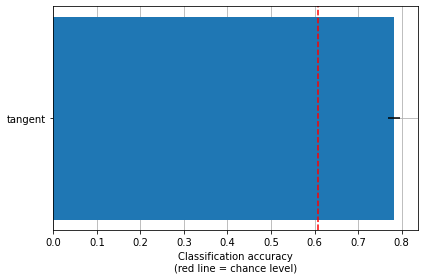

In [103]:
with open('X_MLDL_162_thr25_regions.pickle', 'rb') as handle:
    sub_X_dict = pickle.load(handle)

with open('Y_MLDL_162_thr25_regions.pickle', 'rb') as y_handle:
    sub_Y_dict = pickle.load(y_handle)
    
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029',
             '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', 
             '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', 
             '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', 
             '100', '101']

scores = model_connectome(sub_X_dict, sub_Y_dict, set(good_subs), C = 0.005, n_splits = 30, exclude_size = [10, 65], fconn_types = ['tangent'])

CHANCE:  0.6107816711590297
MEAN MODEL ACC:  [0.7824717765894236]


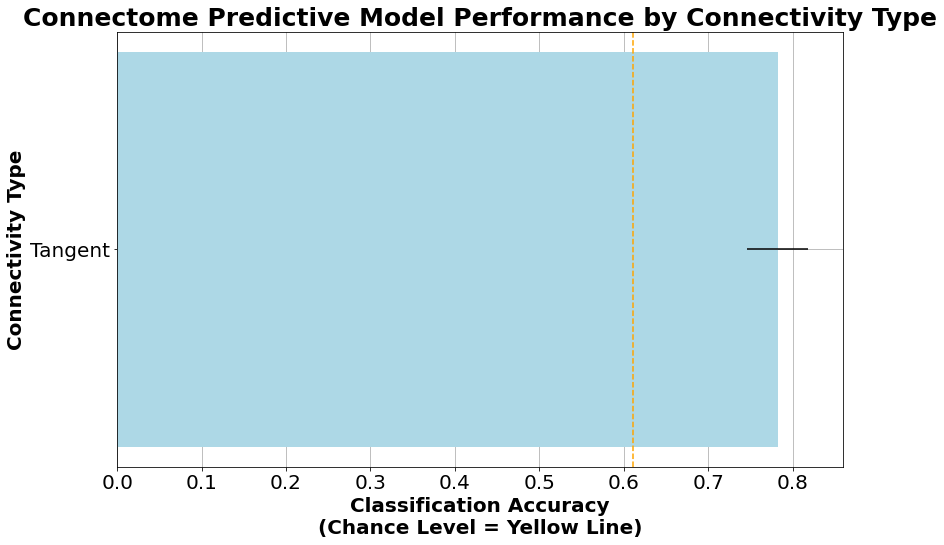

In [106]:
X, y, subjects = return_Xy_data(sub_X_dict, sub_Y_dict, set(good_subs), exclude_size = [10, 65])
kinds = ['tangent']

chance_level = np.mean(y)
print('CHANCE: ', chance_level)
mean_scores = [np.mean(scores[kind]) for kind in kinds]
print('MEAN MODEL ACC: ', mean_scores)
scores_ci = [(1.96 * np.std(scores[kind])/np.mean(scores[kind])) for kind in kinds]


plt.figure(figsize=(13, 8), facecolor = 'white')
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_ci, color = 'lightblue')
yticks = [k.replace(' ', '\n').title() for k in kinds]
plt.yticks(positions, yticks, fontsize = 20)
plt.xticks(fontsize = 20)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(chance_level, color='orange', linestyle='--')
plt.xlabel('Classification Accuracy\n(Chance Level = Yellow Line)', fontweight = 'bold', fontsize = 20)
plt.ylabel('Connectivity Type', fontweight = 'bold', fontsize = 20)
plt.title('Connectome Predictive Model Performance by Connectivity Type', fontweight = 'bold', fontsize = 25)



plt.savefig('cpm_perf_subset.png')

In [107]:
def best_model(ts_array, classes, kind, C, n_splits):
    scores = []
    high_score = 0
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.3)
    count = 0
    
    
    for train, test in cv.split(ts_array, classes):
            count += 1
            pct_complete = (count/n_splits) * 100
            print("%0.3f Percent Complete" % pct_complete,  end = "\r", flush = True)
            
            connectivity = ConnectivityMeasure(kind = kind, vectorize = True, discard_diagonal = True) # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
            connectomes = connectivity.fit_transform(ts_array[train])

            classifier = LinearSVC(C = C).fit(connectomes, classes[train])
            predictions = classifier.predict(connectivity.transform(ts_array[test]))
            acc_score = accuracy_score(classes[test], predictions)
            scores.append(acc_score) 
            
            if acc_score > high_score:
                best_model = classifier
                high_score = acc_score
                

    
    return scores, best_model
            

scores, best_model = best_model(X, y, 'tangent', 0.005, 10)

# save the model to disk
filename = 'MLDL-162-subset_bestmodel.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [110]:
connectivity = ConnectivityMeasure(kind = 'tangent', vectorize = True, discard_diagonal = True)
connectivity.fit_transform(X)

def create_binned_performance(X, y, model, connectivity):
    window_size, true_accuracy, pred_accuracy, correct_prediction = [], [], [], []
    
    for index, connectome in enumerate(X):
        window_size.append(connectome.shape[0])
        true_accuracy.append(y[index])
        pred_accuracy.append(best_model.predict(connectivity.transform([X[index]]))[0])
        correct_prediction.append(y[index] == best_model.predict(connectivity.transform([X[index]]))[0])
        
    
    d = {'window_size': window_size, 'true_acc': true_accuracy, 'pred_acc': pred_accuracy, 'correct_prediction': correct_prediction}
    best_model_df = pandas.DataFrame(d)
    return best_model_df
    

best_model_df = create_binned_performance(X, y, best_model, connectivity)

R: -0.032	p-value: 0.167


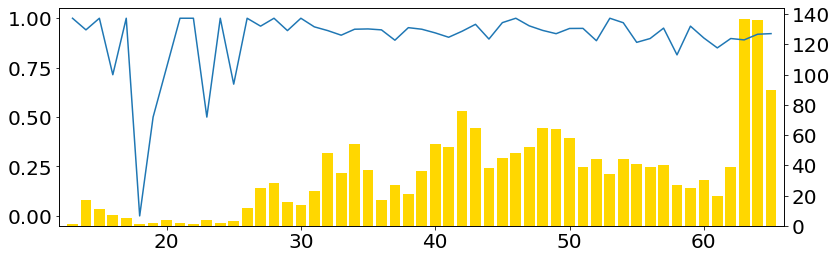

In [122]:
size_by_correct = best_model_df[['window_size', 'correct_prediction']].groupby('window_size').mean()
size_by_correct['number'] = best_model_df[['window_size', 'correct_prediction']].groupby('window_size').count()
size_by_correct['acc'] = best_model_df[['window_size', 'true_acc']].groupby('window_size').mean()

sbc = size_by_correct[size_by_correct.number >= 0]

fig = plt.figure(figsize=(13, 4
                         ), facecolor = 'white')
ax1 = fig.add_subplot(111)
ax1.plot(list(sbc.index), sbc.correct_prediction, zorder = 1)



ax2 = ax1.twinx()
ax2.bar(list(sbc.index), sbc.number, color = 'gold')

labels = pandas.qcut(list(sbc.index), q=q_num).unique()
ax1.set_zorder(10)
ax1.patch.set_visible(False)


ax1.tick_params(axis='both', labelsize = 20)
plt.yticks(fontsize = 20)
plt.xlim(12, 66)


r, p = scipy.stats.pearsonr(best_model_df.window_size, best_model_df.correct_prediction)
print("R: %.3f\tp-value: %.3f" % (r, p))

plt.savefig('tan_perf_trialduration.png')

In [ ]:
from scipy import stats

print("Tangent Distribution: " + str(stats.shapiro(scores1)))
print("Correlation Distribution: " + str(stats.shapiro(scores2)))
print('Degrees of Freedom: ' + str(len(scores1) - 1))

print('\nPaired T-Test Results: ' + str(stats.ttest_rel(scores1, scores2)))

w, p = stats.wilcoxon(scores1 - scores2)
print('Wilcoxon Signed-Rank Test Results: ' + str(stats.wilcoxon(scores1 - scores2)))

#Compute the difference between the results
diff = [y - x for y, x in zip(scores1, scores2)]
#Comopute the mean of differences
d_bar = np.mean(diff)
#compute the variance of differences
sigma2 = np.var(diff)
#compute the number of data points used for training 
n1 = len(y)/2
#compute the number of data points used for testing 
n2 = len(y)/2
#compute the total number of data points
n = len(y)
#compute the modified variance
sigma2_mod = sigma2 * (1/n + n2/n1)
#compute the t_static
t_static =  d_bar / np.sqrt(sigma2_mod)
from scipy.stats import t
#Compute p-value and plot the results 
Pvalue = ((1 - t.cdf(t_static, n-1))*200)
print('Paired Corrected Resampled T-Test Results: \nT-statistic = %.3f \t p-value = %f' % (t_static, Pvalue))

## Model Performance as a Function of Participant Performance
Create a list of subject nums equal to the number of total trials completed by good_subs

In [ ]:
connectivity = ConnectivityMeasure(kind = 'tangent', vectorize = True, discard_diagonal = True)
connectivity.fit_transform(X)

In [ ]:
def create_binned_performance(X, y, model, connectivity, subjects):
    window_size, true_accuracy, pred_accuracy, correct_prediction = [], [], [], []
    
    for index, connectome in enumerate(X):
        window_size.append(connectome.shape[0])
        true_accuracy.append(y[index])
        pred_accuracy.append(best_model.predict(connectivity.transform([X[index]]))[0])
        correct_prediction.append(y[index] == best_model.predict(connectivity.transform([X[index]]))[0])
        print("\r %03f Percent Complete" % (index/len(y)*100), end = "")
    
    d = {'subject': subjects, 'window_size': window_size, 'true_acc': true_accuracy, 'pred_acc': pred_accuracy, 'model_correct': correct_prediction}
    best_model_df = pandas.DataFrame(d)
    return best_model_df
    
print("Computing best model data frame")
best_model_df = create_binned_performance(X, y, best_model, connectivity, subjects)

In [ ]:
performance_bysubject = best_model_df.groupby('subject', as_index=False)['model_correct'].mean()
subject_mean_acc = best_model_df.groupby('subject', as_index=False)['true_acc'].mean()
model_perf_by_subject = pandas.merge(subject_mean_acc, performance_bysubject, on = 'subject')

seaborn.regplot(x = 'model_correct', y = 'true_acc', data = model_perf_by_subject)
r, p = scipy.stats.pearsonr(model_perf_by_subject.model_correct, model_perf_by_subject.true_acc)
print("R: %.3f\tp-value: %f" % (r, p))